In [71]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from typing import Tuple

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, tv_tensors
from torchvision.transforms import functional as F
from torchvision.transforms import v2
from skimage import io
import cv2
import random

import torch.optim as optim
from tqdm.notebook import tqdm

from pydantic import BaseModel

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
folder_path = 'drive/My Drive/DTU/Deep Learning/project/carseg_data_2/images/photo'
file_list = os.listdir(folder_path)

array_path = 'drive/My Drive/DTU/Deep Learning/project/carseg_data/arrays'

path_photo_no_seg = os.path.join(folder_path, 'no_segmentation')
list_photo_no_seg = os.listdir(path_photo_no_seg)

path_photo_with_seg = os.path.join(folder_path, 'with_segmentation')
list_photo_with_seg = os.listdir(path_photo_no_seg)

In [14]:
class Label(BaseModel):
    class_value: int
    color: str
    car_part: str

    def to_rgb(self):
        return matplotlib.colors.to_rgb(self.color)


class_values = range(1, 10)
colors = ["orange", "darkgreen", "yellow", "cyan", "purple", "lightgreen", "blue", "pink", "white"]
car_parts = ["hood", "front door", "rear door", "frame", "rear quater panel", "trunk lid", "fender", "bumper", "rest of car"]

classes = [Label(class_value = cv, color=c, car_part=cp) for cv, c, cp in zip(class_values, colors, car_parts)]

class_to_color = {c.class_value : c.to_rgb() for c in classes}

def color_by_class(img_car, labels):
    img_mask = np.zeros_like(img_car)

    for class_value, color in class_to_color.items():
        img_mask[labels == class_value] = color

    return img_mask


In [184]:
def transform(image, label):
    # Randomly scale the image and label
    scale_x = random.uniform(0.875, 1.2)
    scale_y = random.uniform(0.875, 1.2)
    image = cv2.resize(image, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_LINEAR)
    label = cv2.resize(label, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_NEAREST)

    # Randomly crop the image and label
    final_shape = (224, 224)
    rows, cols, _ = image.shape
    x = random.randint(0, cols - final_shape[1])
    y = random.randint(0, rows - final_shape[0])
    image = image[y:y + final_shape[0], x:x + final_shape[1]]
    label = label[y:y + final_shape[0], x:x + final_shape[1]]

    # Randomly adjust the color of the image
    r_adjust = random.uniform(0.5, 1.5)
    g_adjust = random.uniform(0.5, 1.5)
    b_adjust = random.uniform(0.5, 1.5)
    image[:, :, 0] = image[:, :, 0] * r_adjust
    image[:, :, 1] = image[:, :, 1] * g_adjust
    image[:, :, 2] = image[:, :, 2] * b_adjust
    image[image > 255] = 255
    image[image < 0] = 0

    # Flip the image and label horizontally with a 50% chance
    if random.choice([True, False]):
        image = cv2.flip(image, 1)  # Horizontal flip
        label = cv2.flip(label, 1)  # Horizontal flip for label

    # Flip the image and label vertically with a 50% chance
    if random.choice([True, False]):
        image = cv2.flip(image, 0)  # Vertical flip
        label = cv2.flip(label, 0)  # Vertical flip for label

    # Rotate the image and label slightly (up to +/- 15 degrees)
    angle = random.uniform(-15, 15)
    rows, cols, _ = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    label = cv2.warpAffine(label, rotation_matrix, (cols, rows), flags=cv2.INTER_NEAREST)

    return image, label

In [185]:
class SegmentationDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.file_names = [f for f in os.listdir(folder_path) if f.endswith('.npy')]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, self.file_names[idx])
        array = np.load(file_path)

        # Splitting into image and label
        image = array[:, :, 0:3]
        label = array[:, :, 3] /10


        # Min-Max normalization for the image
        image = (image - np.min(image)) / (np.max(image) - np.min(image))

        # Resize
        #image = F.resize(image, (256, 256))
        #label = F.resize(label, (256, 256), interpolation=F.InterpolationMode.NEAREST)  # Use NEAREST for labels to avoid creating new label values

        # Apply transforms if any
        if self.transform is not None:
            image, label = self.transform(image, label)
            #image = self.transform(image)
            #label = self.transform(label)

        # Convert arrays to PyTorch tensors
        image = torch.from_numpy(image).permute(2, 0, 1).float()  # Convert to (C, H, W) format
        label = torch.from_numpy(label).long()  # Convert to long as it's a label

        return image, label


# Assuming array_path is defined
dataset = SegmentationDataset(folder_path=array_path, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

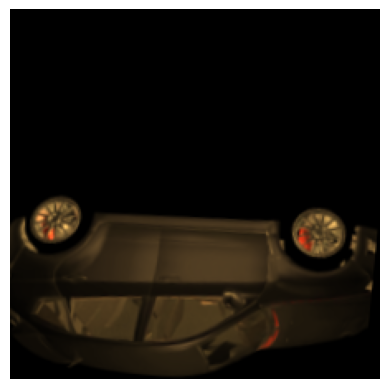

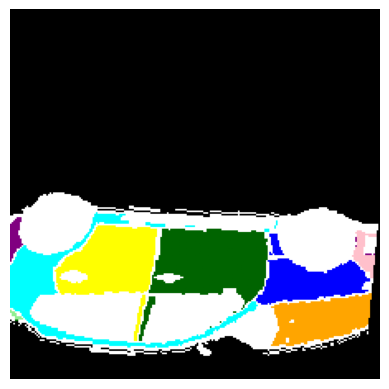

In [187]:
#visualize dataloader
import matplotlib.pyplot as plt

images, masks = next(iter(dataloader))

# Plot image
img_car = images[0].permute(1, 2, 0).numpy()

img_mask = masks[0].numpy()
img_mask = color_by_class(img_car, img_mask)

plt.imshow(img_car)
plt.axis('off')
plt.show()

plt.imshow(img_mask)
plt.axis('off')
plt.show()

In [188]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Contracting path
        self.enc1 = self.conv_block(in_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Expanding path
        self.up1 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128 + 64, 64)
        self.up2 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(64 + 32, 32)

        self.out = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Contracting path
        c1 = self.enc1(x)
        p1 = self.pool(c1)

        c2 = self.enc2(p1)
        p2 = self.pool(c2)

        c3 = self.enc3(p2)

        # Expanding path
        up1 = self.up1(c3)
        merge1 = torch.cat([up1, c2], dim=1)
        d1 = self.dec1(merge1)

        up2 = self.up2(d1)
        merge2 = torch.cat([up2, c1], dim=1)
        d2 = self.dec2(merge2)

        out = self.out(d2)
        return out

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

# Create the model
model = UNet(in_channels=3, out_channels=10)
print(model)

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up1): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
  (dec1): Sequential(
    (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d

In [189]:
# Assuming you have a dataloader 'dataloader' and your device is 'cuda' if you have a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = UNet(in_channels=3, out_channels=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10


for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Wrap dataloader with tqdm for a loading bar
    for images, masks in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")

Epoch 1/10:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [1/10] Loss: 0.7972


Epoch 2/10:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [2/10] Loss: 0.5756


Epoch 3/10:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [3/10] Loss: 0.5307


Epoch 4/10:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [4/10] Loss: 0.5105


Epoch 5/10:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [5/10] Loss: 0.4945


Epoch 6/10:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [6/10] Loss: 0.4705


Epoch 7/10:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [7/10] Loss: 0.4517


Epoch 8/10:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [8/10] Loss: 0.4266


Epoch 9/10:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [9/10] Loss: 0.4091


Epoch 10/10:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [10/10] Loss: 0.3876


In [190]:
def show_comparison(img, true_mask, pred_mask):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Actual mask
    ax2.imshow(true_mask)
    ax2.set_title('Actual Mask')
    ax2.axis('off')

    # Predicted mask
    ax3.imshow(pred_mask)
    ax3.set_title('Predicted Mask')
    ax3.axis('off')

    plt.show()

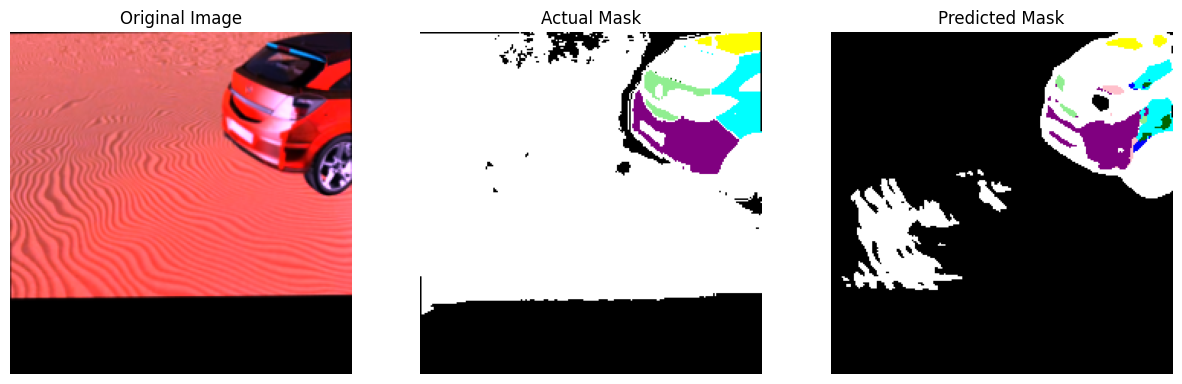

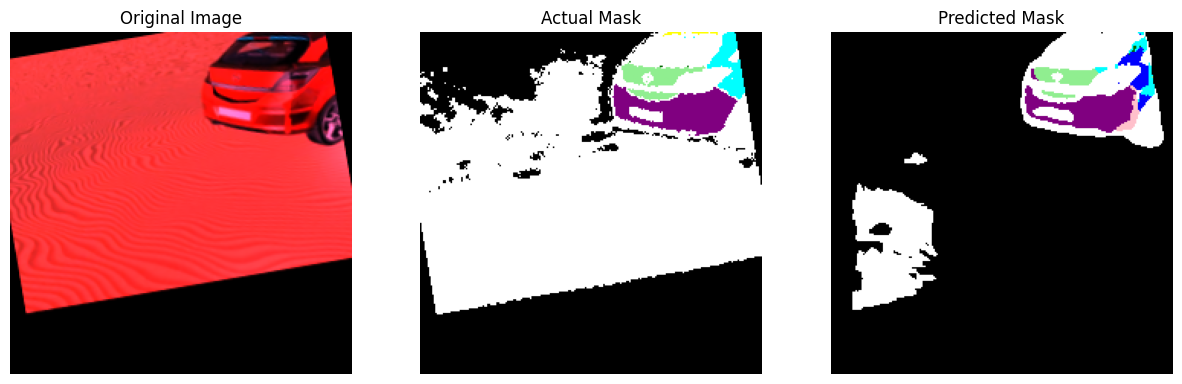

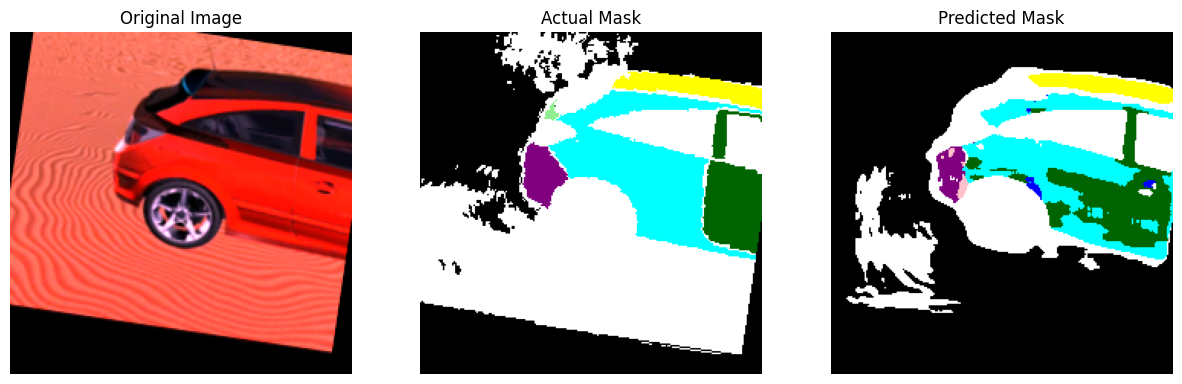

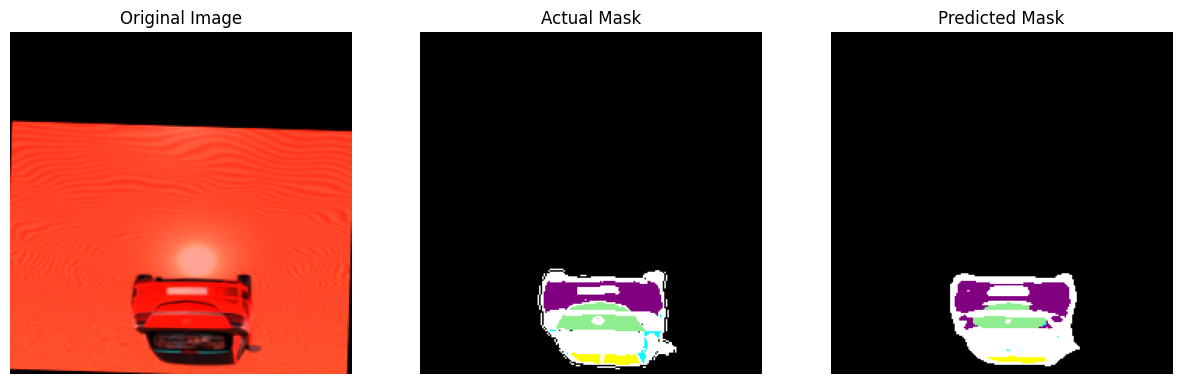

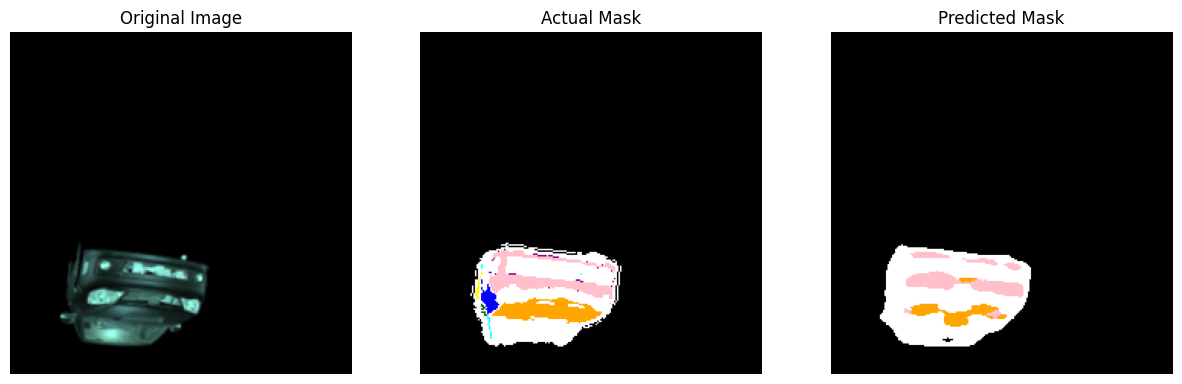

In [192]:
# Ensure model is in eval mode
model.eval()

# Get a batch of images and masks from the dataloader
images, masks = next(iter(dataloader))
images, masks = images.to(device), masks.to(device)

# Predict masks with the model
with torch.no_grad():
    preds = model(images)

# Take the argmax to get the class label for each pixel
pred_masks = preds.argmax(dim=1)

# Select the number of examples to plot
num_examples = 5

for i in range(num_examples):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    true_mask = masks[i].cpu().numpy()
    true_mask = color_by_class(img, true_mask)
    pred_mask = pred_masks[i].cpu().numpy()
    pred_mask = color_by_class(img, pred_mask)
    show_comparison(img, true_mask, pred_mask)